In [70]:
!pip3 install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

In [72]:
df = pd.read_csv("us-counties-2020.csv")
df.head()

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
4,2020-01-24,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0


In [73]:
# Remove not usefull columns
df = df.drop(['geoid', 'county','cases_avg_per_100k','cases_avg_per_100k','deaths_avg_per_100k'], axis=1)

In [74]:
# Simplify column names
df.columns = ['date',  'state', 'cases', 'cases_avg', 'deaths', 'deaths_avg']
targets = ['cases_avg']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,state,cases,cases_avg,deaths,deaths_avg
0,2020-01-21,Washington,1,0.14,0,0.0
1,2020-01-22,Washington,0,0.14,0,0.0
2,2020-01-23,Washington,0,0.14,0,0.0
3,2020-01-24,Washington,0,0.14,0,0.0
4,2020-01-24,Illinois,1,0.14,0,0.0


In [75]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,state,cases,cases_avg,deaths,deaths_avg
0,2020-01-21 00:00:00,Washington,1,0.140000,0,0.000000
1,2020-01-22 00:00:00,Washington,0,0.140000,0,0.000000
2,2020-01-23 00:00:00,Washington,0,0.140000,0,0.000000
3,2020-01-24 00:00:00,Washington,0,0.140000,0,0.000000
4,2020-01-24 00:00:00,Illinois,1,0.140000,0,0.000000


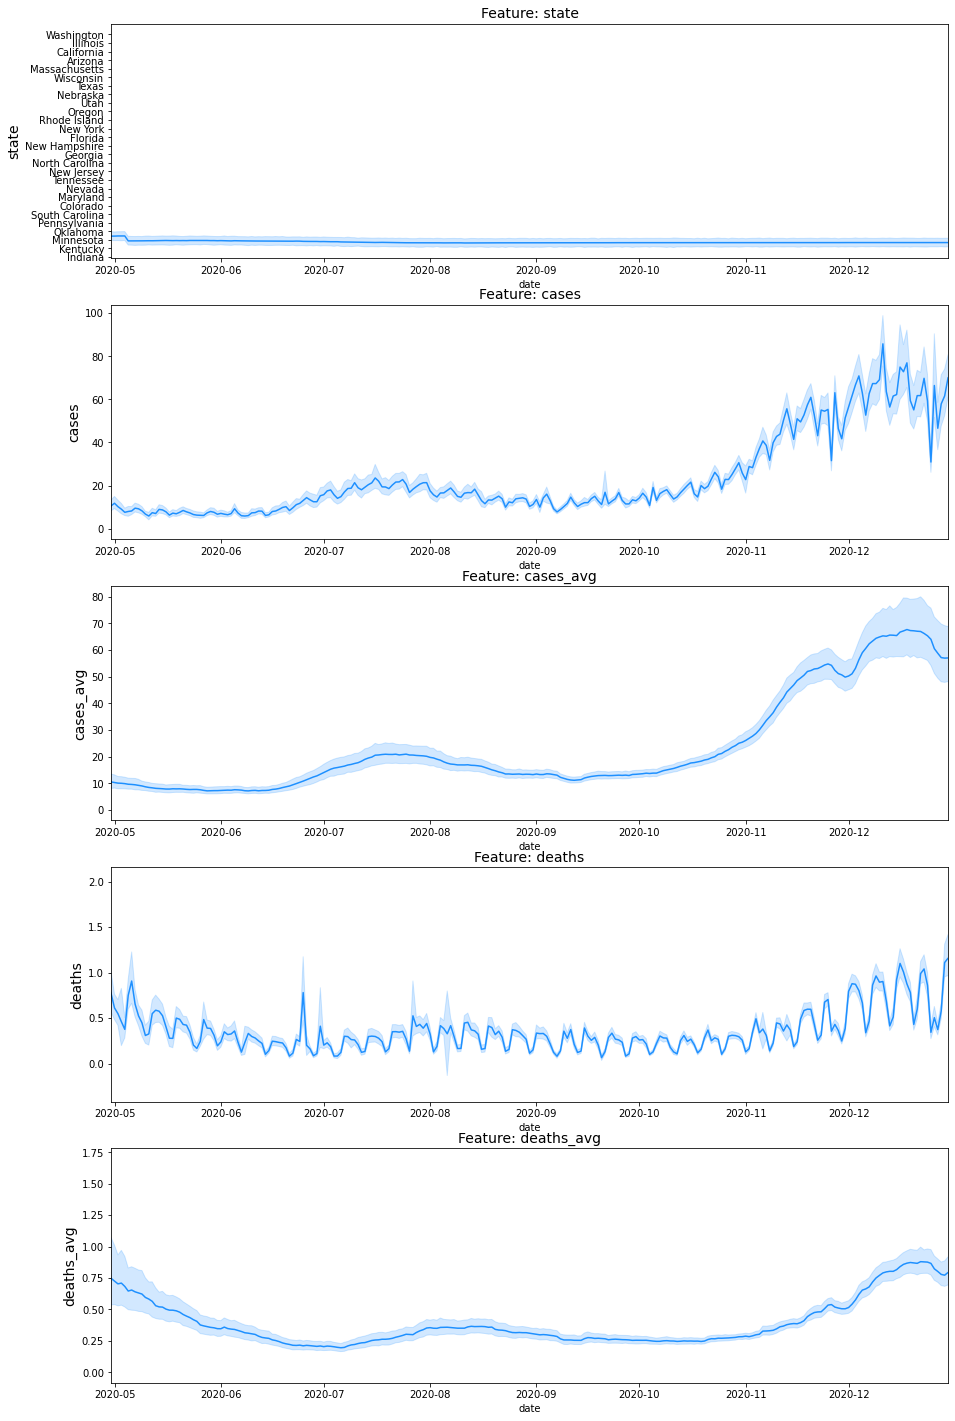

In [76]:
# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])    

In [77]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2020-01-21,NaT
1,2020-01-22,1 days
2,2020-01-23,1 days
3,2020-01-24,1 days
4,2020-01-24,0 days


In [78]:
df['delta'].sum(), df['delta'].count()

(Timedelta('345 days 00:00:00'), 889997)

In [79]:
df = df.drop('delta', axis=1)
df.isna().sum()

date          0
state         0
cases         0
cases_avg     0
deaths        0
deaths_avg    0
dtype: int64

(737545.0, 737789.0)

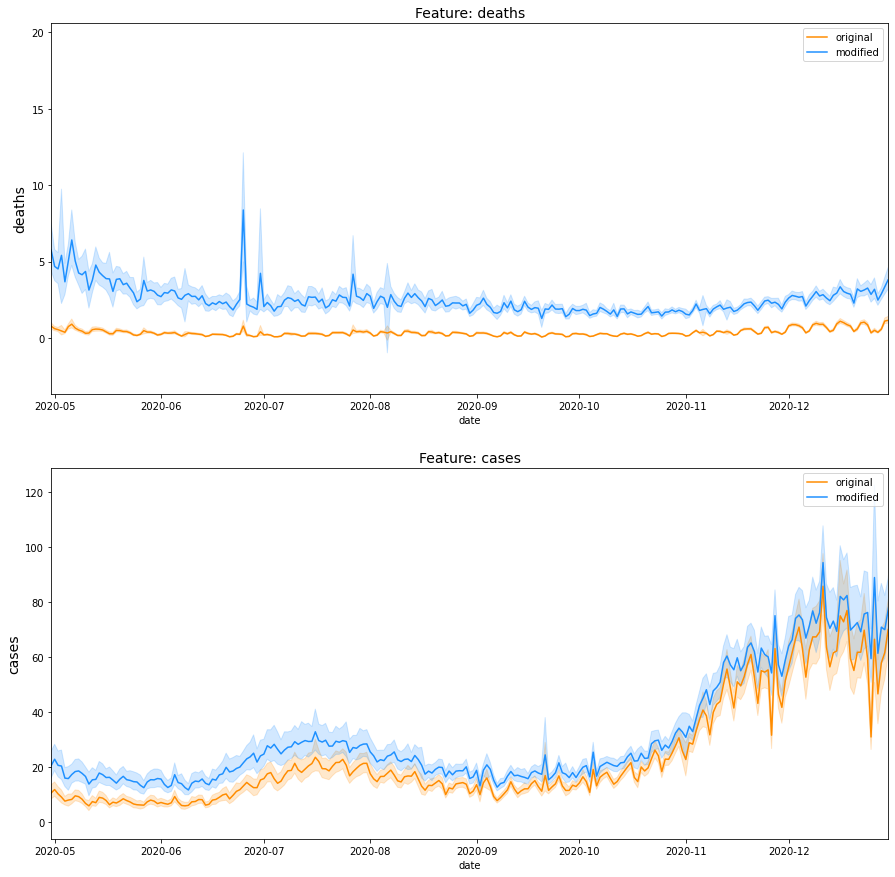

In [80]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['deaths'].copy()
df['deaths'] = df['deaths'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['deaths'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: deaths', fontsize=14)
ax[0].set_ylabel(ylabel='deaths', fontsize=14)
ax[0].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])

old_drainage = df['cases'].copy()
df['cases'] = df['cases'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['cases'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: cases', fontsize=14)
ax[1].set_ylabel(ylabel='cases', fontsize=14)
ax[1].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])

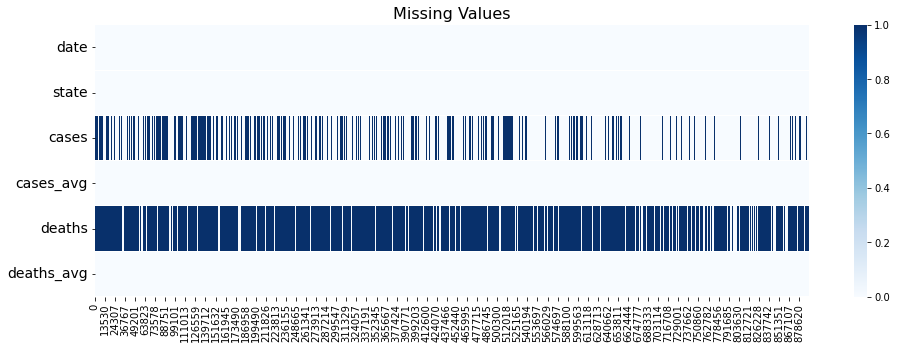

In [81]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

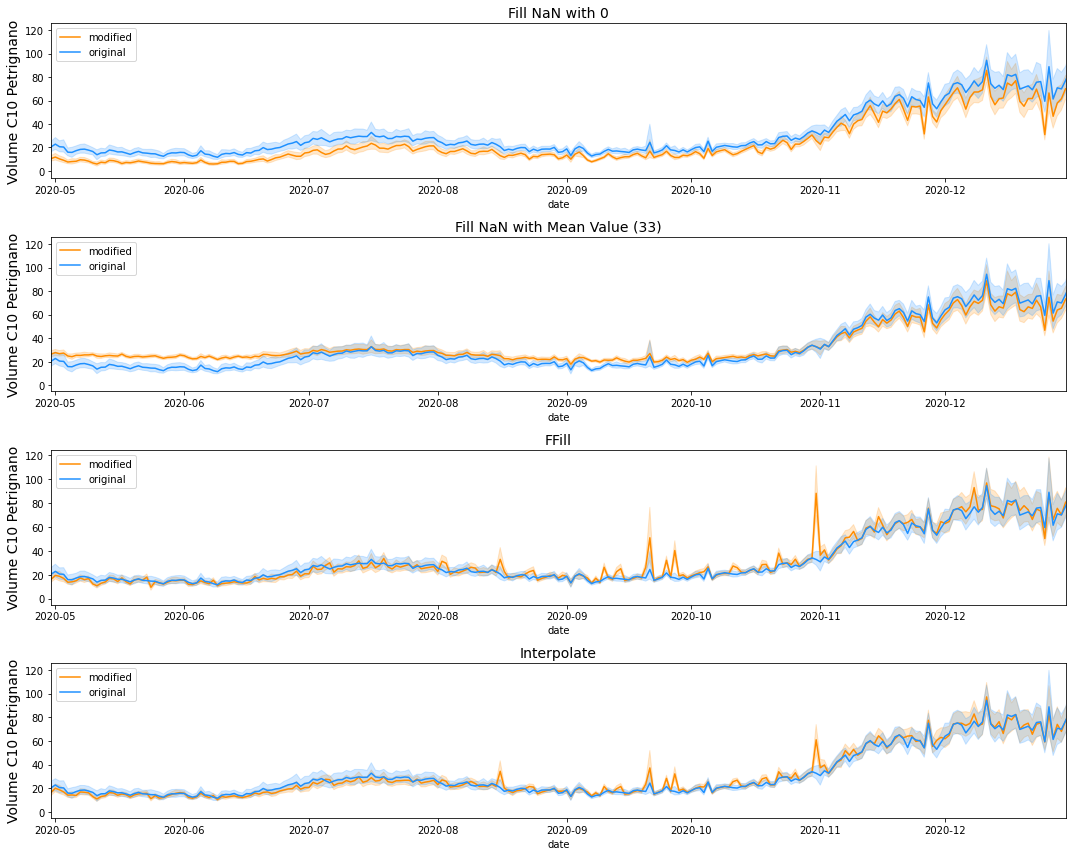

In [82]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['cases'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['cases'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['cases'].mean()
sns.lineplot(x=df['date'], y=df['cases'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['cases'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['cases'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['cases'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['cases'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['cases'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])
    
plt.tight_layout()
plt.show()

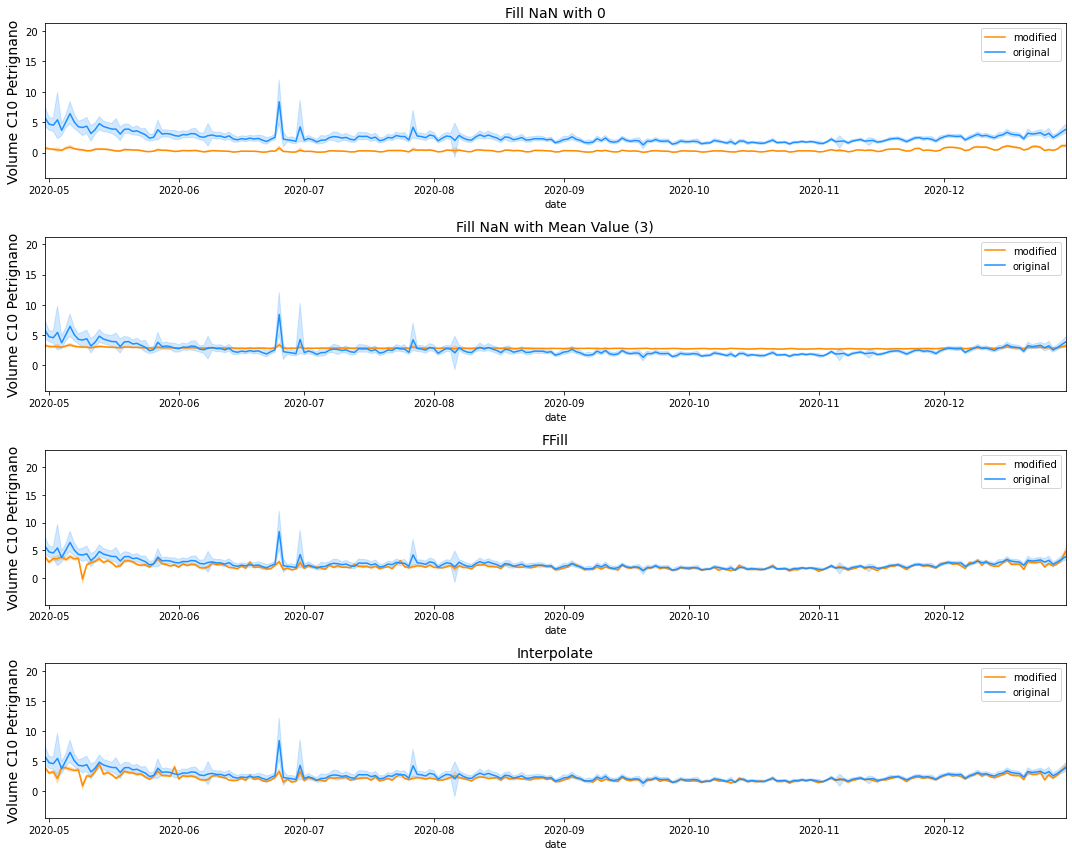

In [83]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['deaths'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['deaths'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['deaths'].mean()
sns.lineplot(x=df['date'], y=df['deaths'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['deaths'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['deaths'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['deaths'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['deaths'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['deaths'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])
    
plt.tight_layout()
plt.show()

In [84]:
df['deaths'] = df['deaths'].interpolate()
df['cases'] = df['cases'].interpolate()


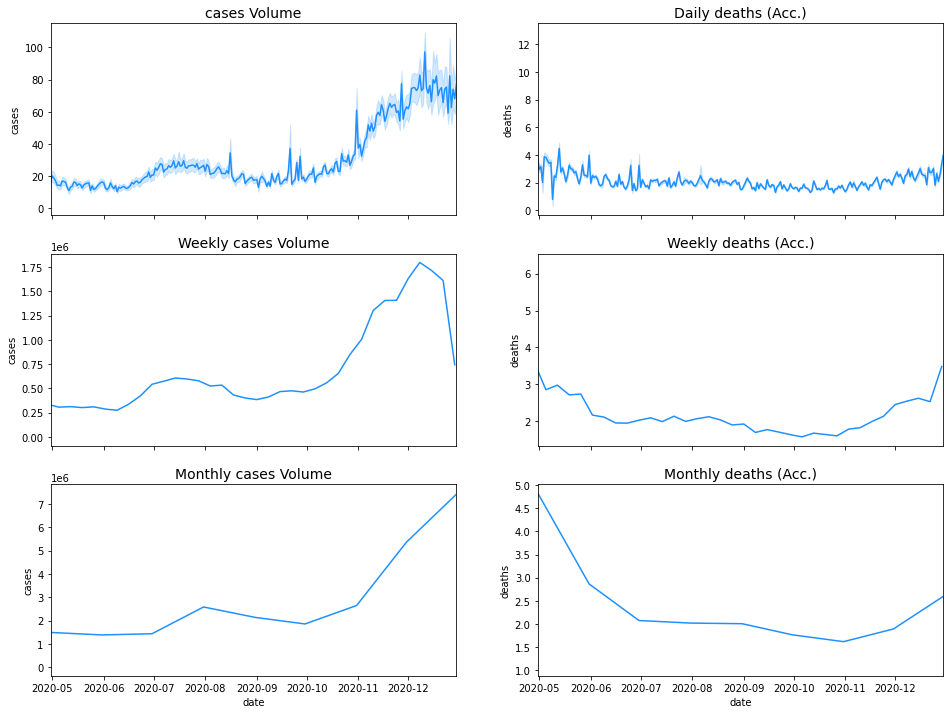

In [85]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(df['date'], df['cases'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('cases Volume', fontsize=14)

resampled_df = df[['date','cases']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['cases'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly cases Volume', fontsize=14)

resampled_df = df[['date','cases']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['cases'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly cases Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])

sns.lineplot(df['date'], df['deaths'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily deaths (Acc.)', fontsize=14)

resampled_df = df[['date','deaths']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['deaths'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly deaths (Acc.)', fontsize=14)

resampled_df = df[['date','deaths']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['deaths'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly deaths (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])
plt.show()

In [86]:
# As we can see, downsample to weekly could smooth the data and hgelp with analysis
downsample = df[['date', 'cases', 'cases_avg', 'deaths', 'deaths_avg']].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

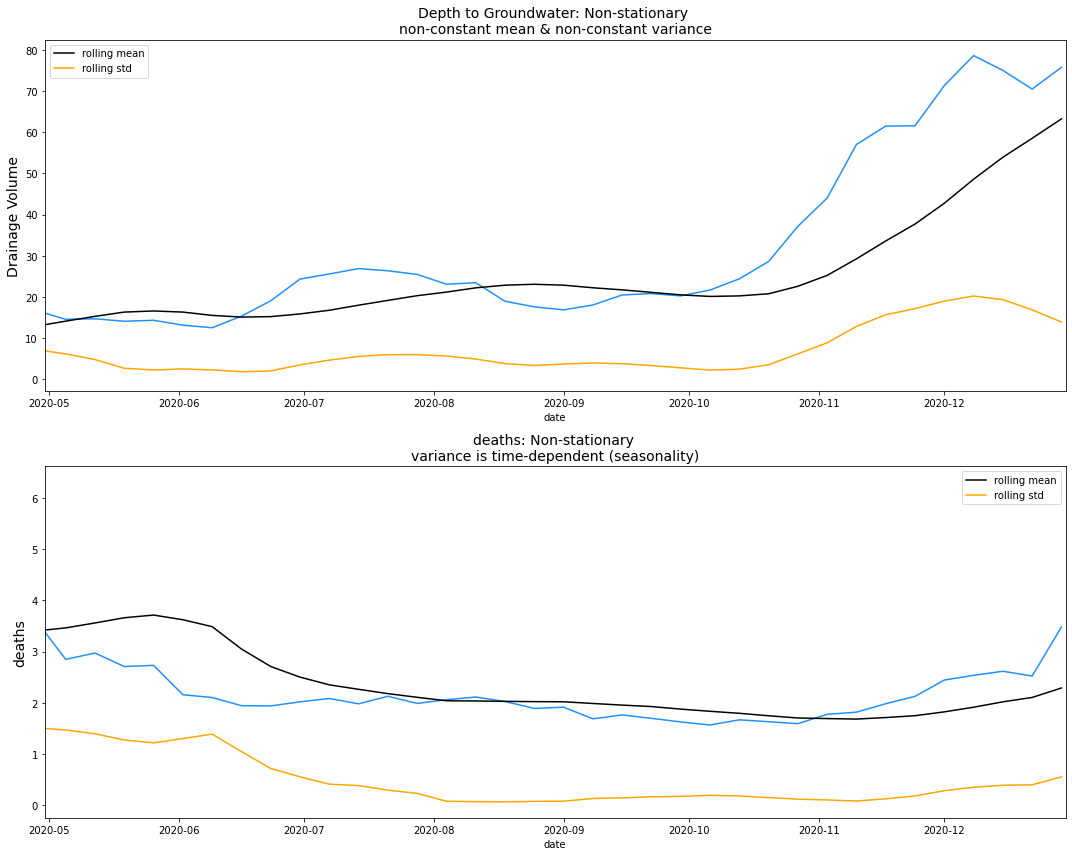

In [87]:
rolling_window = 10
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['cases'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['cases'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['cases'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])

sns.lineplot(x=df['date'], y=df['deaths'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['deaths'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['deaths'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('deaths: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='deaths', fontsize=14)
ax[1].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])

plt.tight_layout()
plt.show()

In [108]:
df['deaths'] = df['deaths'].replace(np.inf, 0)
df['deaths'] = df['deaths'].replace(np.nan, 0)
df['deaths'] = df['deaths'].replace(-np.inf, 0)

df['cases'] = df['cases'].replace(np.inf, 0)
df['cases'] = df['cases'].replace(np.nan, 0)

In [109]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['cases'].values)
result

(-0.22320688946372993,
 0.9356982905141449,
 3,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 204.05834603879157)

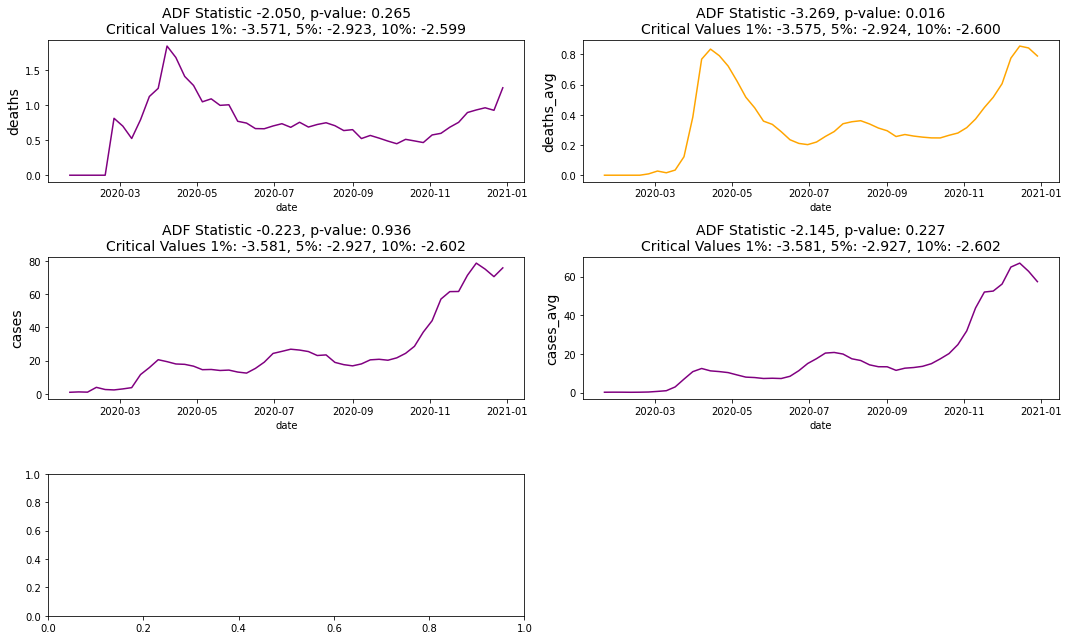

In [110]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['deaths'].values, 'deaths', ax[0, 0])
visualize_adfuller_results(df['cases'].values, 'cases', ax[1, 0])
visualize_adfuller_results(df['deaths_avg'].values, 'deaths_avg', ax[0, 1])
visualize_adfuller_results(df['cases_avg'].values, 'cases_avg', ax[1, 1])
f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()


In [120]:
df['deaths'] = df['deaths'].replace(-np.inf, 0)

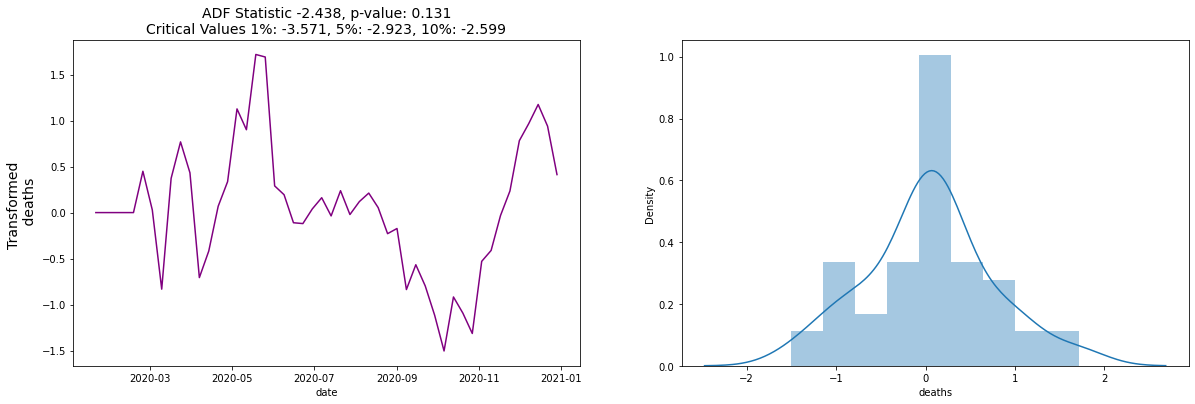

In [123]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['deaths'], 'Transformed \n deaths', ax[0])

sns.distplot(df['deaths'], ax=ax[1])

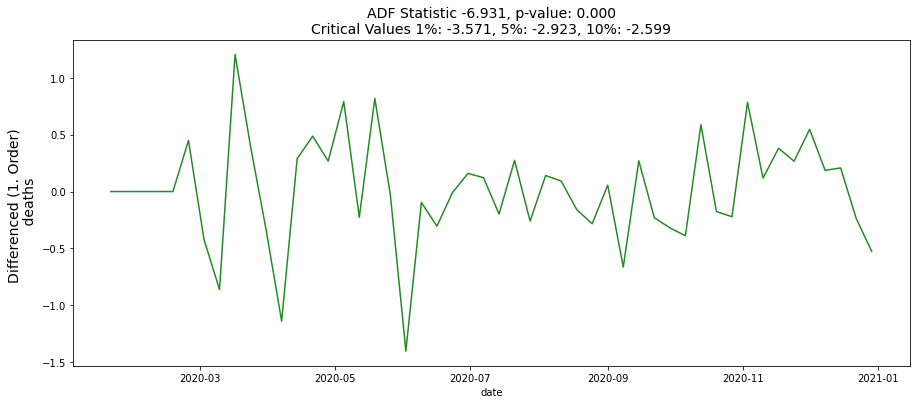

In [124]:
# First Order Differencing
ts_diff = np.diff(df['deaths'])
df['deaths'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['deaths'], 'Differenced (1. Order) \n deaths', ax)